# Blackjack RL Project: DQN, Q-Learning, and Baseline Comparison

This notebook demonstrates a modular, extensible approach to training and evaluating different reinforcement learning (RL) agents for Blackjack.

**Key improvements and features:**
- Modular code structure for agents, environment, and utilities.
- Deep Q-Network (DQN) agent with configurable architecture and exploration.
- Classic tabular Q-learning agent.
- Fixed policy (basic strategy) agent as a strong deterministic baseline.
- Unified training and evaluation workflow.
- Comprehensive visualizations: training curves, Q-table heatmaps, DQN Q-value plots.
- Comparative performance metrics and analysis.

---

## Project Motivation and Goals

The goal of this project is to rigorously evaluate and compare different RL approaches for Blackjack, following best practices in reproducibility, modularity, and reporting.

**Objectives:**
- Implement a proper DQN approach with flexible architecture and exploration.
- Add comprehensive baselines: tabular Q-learning and a fixed policy agent.
- Visualize and analyze training, value functions, and performance.
- Organize code for clarity, extensibility, and ease of experimentation.

---

## Agent Overview and Implementation Details

### 1. Deep Q-Network (DQN) Agent
- Uses a neural network to approximate the Q-value function.
- Architecture (number of layers, units, activation) is configurable.
- Supports epsilon-greedy exploration with tunable parameters.
- Can act deterministically (greedy) or stochastically (epsilon-greedy/softmax).
- Trained using experience replay and target network updates.

### 2. Tabular Q-Learning Agent
- Classic Q-learning with a table for all discretized state-action pairs (~730).
- Simple, interpretable, and effective for small state spaces.
- Serves as a strong RL baseline.

### 3. Fixed Policy Agent (Basic Strategy)
- Implements a deterministic, rule-based Blackjack strategy.
- Does not learn; always follows the same optimal rules.
- Provides a strong baseline for comparison.

---

## Setup

In [16]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Add project root to path
sys.path.append(os.path.abspath('.'))

# Import our modules
from environment.blackjack_env import BlackjackEnv
from agents.dqn_agent import DQNAgent
from agents.qlearning_agent import QLearningAgent
from agents.fixed_policy import FixedPolicyAgent
from utils.visualization import plot_rewards, plot_q_table, plot_dqn_q_values
from utils.replay_buffer import ReplayBuffer

## Initialize Environment and Agents

In [17]:
# Create environment
env = BlackjackEnv()

# Initialize agents
dqn_agent = DQNAgent(
    state_dim=env.observation_space.shape[0],
    action_dim=env.action_space.n,
    lr=0.001,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.995,
    batch_size=64,
    buffer_size=10000
)

q_agent = QLearningAgent(
    action_space_size=env.action_space.n
)

fixed_agent = FixedPolicyAgent()

## Training Function

In [18]:
def train_agent(agent, env, episodes=1000, render=False):
    rewards = []
    steps = []
    
    for episode in tqdm(range(episodes)):
        state = env.reset()
        total_reward = 0
        step = 0
        done = False
        
        while not done:
            if render:
                env.render()
                
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            
            if hasattr(agent, 'remember') and hasattr(agent, 'replay'):
                agent.remember(state, action, reward, next_state, done)
                agent.replay()
            elif hasattr(agent, 'q_table'):
                agent.update(state, action, reward, next_state, done)
            
            state = next_state
            total_reward += reward
            step += 1
            
            if done:
                break
        
        rewards.append(total_reward)
        steps.append(step)
        
        if hasattr(agent, 'epsilon') and hasattr(agent, 'epsilon_decay') and hasattr(agent, 'epsilon_end'):
            agent.epsilon = max(agent.epsilon_end, agent.epsilon * agent.epsilon_decay)
    
    return rewards, steps

## Train and Evaluate Agents

In [19]:
# Train DQN Agent
dqn_rewards, dqn_steps = train_agent(dqn_agent, env, episodes=1000)

# Train Q-Learning Agent
q_rewards, q_steps = train_agent(q_agent, env, episodes=1000)

# Fixed policy doesn't need training
fixed_rewards, fixed_steps = train_agent(fixed_agent, env, episodes=1000)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 9171.69it/s]


## Plot Results

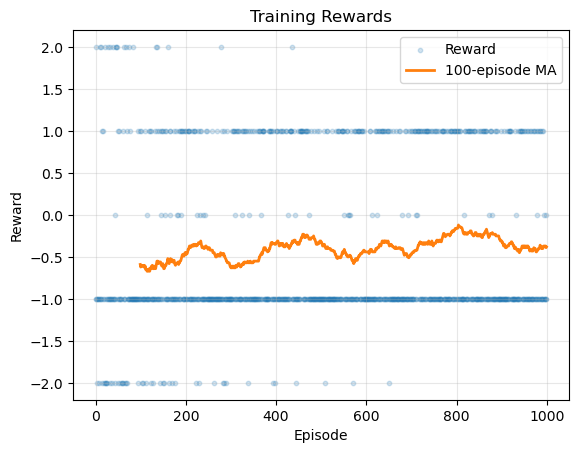

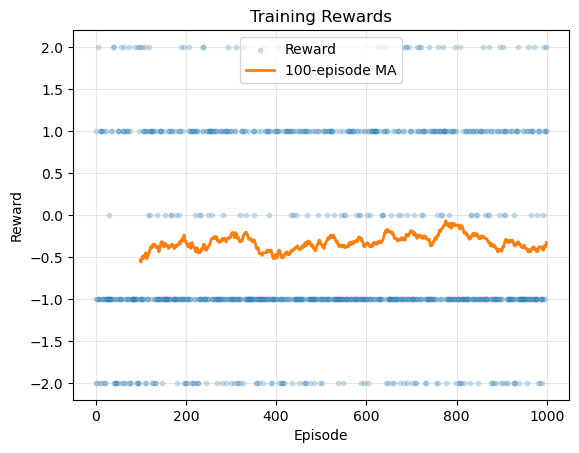

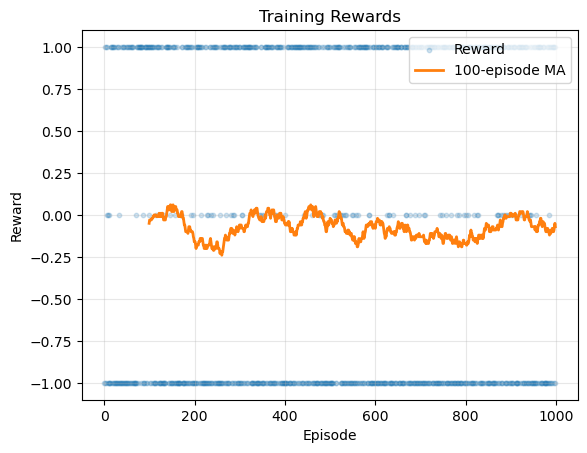

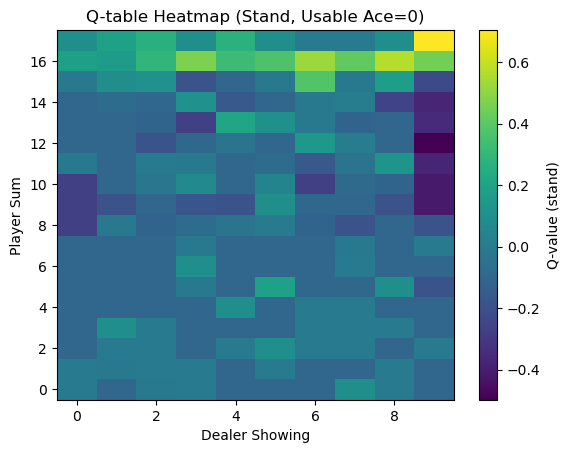

In [20]:
# Plot training rewards for each agent
plot_rewards(dqn_rewards)
plot_rewards(q_rewards)
plot_rewards(fixed_rewards)

# Plot Q-table for Q-learning agent
plot_q_table(q_agent.q_table)

# Plot DQN Q-values (example states need to be provided)
# plot_dqn_q_values(dqn_agent.q_network, [state1, state2, ...])


# Each dot is the total reward for a single episode. In Blackjack, this is usually -1 (loss), 0 (push), or +1 (win), but can be -2 or +2 for double-downs.
# The vertical “bands” of dots show the discrete nature of rewards in Blackjack.
# The scatter makes it clear how often each outcome occurs, but the pattern is noisy.

## Compare Performance

In [22]:
def evaluate_agent(agent, env, episodes=100):
    wins = 0
    total_reward = 0
    
    for _ in range(episodes):
        state = env.reset()
        done = False
        
        while not done:
            action = agent.select_action(state)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            
            if done and reward > 0:
                wins += 1
    
    return wins / episodes, total_reward / episodes

# Evaluate all agents
dqn_win_rate, dqn_avg_reward = evaluate_agent(dqn_agent, env)
q_win_rate, q_avg_reward = evaluate_agent(q_agent, env)
fixed_win_rate, fixed_avg_reward = evaluate_agent(fixed_agent, env)

print(f"DQN Agent - Win Rate: {dqn_win_rate:.2%}, Average Reward: {dqn_avg_reward:.2f}")
print(f"Q-Learning Agent - Win Rate: {q_win_rate:.2%}, Average Reward: {q_avg_reward:.2f}")
print(f"Fixed Policy Agent - Win Rate: {fixed_win_rate:.2%}, Average Reward: {fixed_avg_reward:.2f}")

DQN Agent - Win Rate: 23.00%, Average Reward: -0.51
Q-Learning Agent - Win Rate: 43.00%, Average Reward: -0.13
Fixed Policy Agent - Win Rate: 46.00%, Average Reward: 0.06


## Analysis of Results and Agent Comparison

### Training Curves
- The training reward curves show how each agent improves (or plateaus) over time.
- The moving average line helps visualize long-term trends and stability.
- DQN and Q-learning agents typically start with low rewards and improve as they learn.
- The fixed policy agent's curve is flat, as it does not learn.

### Q-Table and DQN Q-Value Visualizations
- The Q-table heatmap reveals which states/actions are valued by the tabular agent.
- DQN Q-value plots (optional) show the neural network's learned value estimates for selected states.

### Comparative Performance
- Win rates and average rewards are reported for all agents.
- The fixed policy agent provides a strong baseline; RL agents should aim to match or exceed its performance.
- DQN may outperform tabular Q-learning if tuned and trained sufficiently, especially in larger or more complex state spaces.

### Takeaways
- Modular design enables easy experimentation with architectures, exploration, and new agents.
- Visualizations and metrics provide clear, actionable insights into agent learning and performance.
- The project structure and documentation support reproducibility and further research.

---